In [ ]:
!pip install openpyxl tqdm python-docx openai
!pip install scikit-learn rouge-score sacrebleu
!pip install nltk bert-score
!pip install fireducks

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 13.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0


In [ ]:
import os, re, json, glob
import fireducks.pandas as pd
from tqdm import tqdm
from docx import Document
import docx

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import sacrebleu  # for BLEU score
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn

from google.colab import userdata
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# path to input JSONs and output folder
excel_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Radiology-manual-annotations.xlsx"
INPUT_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Medical reports for cases/"
OUTPUT_DIR = r"/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2"

# checks output directory is real
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [ ]:
nltk.download('punkt_tab')  # Required for METEOR tokenization

packages = ['punkt', 'wordnet', 'stopwords']  # Add more as needed
#for pkg in packages:
#    try:
#        nltk.data.find(f'corpora/{pkg}' if pkg != 'punkt' else f'tokenizers/{pkg}')
#    except LookupError:
#        nltk.download(pkg)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# ===== DEFINE DIRECTORIES AND PATIENT IDs =====

# 1. Define GT_DIR and GEN_DIR (missing from your code)
GT_DIR = INPUT_DIR   # Ground truth directory
GEN_DIR = OUTPUT_DIR # Generated reports directory

print(f"GT Directory: {GT_DIR}")
print(f"GEN Directory: {GEN_DIR}")

# 2. Define which patients to evaluate
# OPTION A: All 326 patients (simplest)
ids_to_eval = list(range(1, 327))  # 1 through 326

print(f"\nWill evaluate {len(ids_to_eval)} patients")
print(f"First 5 IDs: {ids_to_eval[:5]}")
print(f"Last 5 IDs: {ids_to_eval[-5:]}")

# OPTION B: Check files exist first (recommended)
import os

ids_to_eval_checked = []
missing_files = []

print("\nChecking which files exist...")
for pid in ids_to_eval:
    gt_path = os.path.join(GT_DIR, f"P{pid}.docx")
    gen_path = os.path.join(GEN_DIR, f"P{pid}_report.docx")

    gt_exists = os.path.exists(gt_path)
    gen_exists = os.path.exists(gen_path)

    if gt_exists and gen_exists:
        ids_to_eval_checked.append(pid)
    else:
        missing_files.append(pid)
        if not gt_exists:
            print(f"  ⚠️ P{pid}: Missing ground truth")
        if not gen_exists:
            print(f"  ⚠️ P{pid}: Missing generated report")

print(f"\n✅ Found {len(ids_to_eval_checked)} patients with BOTH files")
print(f"❌ Missing {len(missing_files)} patients")

# Use the checked list
ids_to_eval = ids_to_eval_checked

GT Directory: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/Medical reports for cases/
GEN Directory: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2

Will evaluate 326 patients
First 5 IDs: [1, 2, 3, 4, 5]
Last 5 IDs: [322, 323, 324, 325, 326]

Checking which files exist...

✅ Found 326 patients with BOTH files
❌ Missing 0 patients


In [ ]:
# Initialize ROUGE scorer
rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)

# Define docx_to_text function if not defined elsewhere
def docx_to_text(path):
    doc = docx.Document(path)
    return "\n".join(p.text for p in doc.paragraphs)

rows = []
hyp_texts, ref_texts, pids_for_bert = [], [], []

for pid in tqdm(ids_to_eval, desc="Loading texts"):
    gt_path = os.path.join(GT_DIR, f"P{pid}.docx")
    gen_path = os.path.join(GEN_DIR, f"P{pid}_report.docx")

    if not (os.path.exists(gt_path) and os.path.exists(gen_path)):
        print(f"Skipping {pid}: missing file")
        continue

    ref_text = docx_to_text(gt_path)
    hyp_text = docx_to_text(gen_path)

    # ---------- ROUGE ----------
    r_scores = rouge_scorer_obj.score(ref_text, hyp_text)
    rouge1_f = r_scores["rouge1"].fmeasure      # already 0–1
    rougeL_f = r_scores["rougeL"].fmeasure      # already 0–1

    # ---------- BLEU ----------
    # sacrebleu returns a *percentage* (0–100), so divide by 100 to get 0–1
    bleu_score_raw = sacrebleu.corpus_bleu(
        [hyp_text],          # list of hypothesis strings
        [[ref_text]]         # list of reference-lists
    ).score
    bleu_score = bleu_score_raw / 100.0         # normalize to 0–1

    # ---------- METEOR ----------
    # Remove the redundant import statement inside the loop
    ref_tokens = word_tokenize(ref_text.lower())
    hyp_tokens = word_tokenize(hyp_text.lower())
    meteor_val = meteor_score([ref_tokens], hyp_tokens)  # already 0–1

    # Store for BERTScore batch
    ref_texts.append(ref_text)
    hyp_texts.append(hyp_text)
    pids_for_bert.append(pid)

    rows.append({
        "patient_id": pid,
        "rouge1_f": rouge1_f,
        "rougeL_f": rougeL_f,
        "bleu": bleu_score,          # now 0–1
        "meteor": meteor_val,
        # BERTScore will be added later
    })


Loading texts: 100%|██████████| 326/326 [00:34<00:00,  9.53it/s]


In [ ]:
# ---------- BERTScore (batched) ----------
print("Computing BERTScore (may take 1–2 mins)...")
P, R, F1 = bert_score_fn(hyp_texts, ref_texts, lang="en", verbose=True)
bert_f1_list = F1.tolist()   # already 0–1

# Merge BERTScore into rows
metrics_df = pd.DataFrame(rows)
metrics_df["bertscore_f1"] = bert_f1_list

# Save/preview
print(metrics_df.head())

# Optional: Save to CSV
output_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/metrics_results.csv"
metrics_df.to_csv(output_path, index=False)
print(f"Metrics saved to {output_path}")

Computing BERTScore (may take 1–2 mins)...


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/11 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/6 [00:00<?, ?it/s]

done in 25.34 seconds, 12.86 sentences/sec
   patient_id  rouge1_f  rougeL_f      bleu    meteor  bertscore_f1
0           1  0.848485  0.767677  0.567012  0.796777      0.926182
1           2  0.551237  0.452297  0.300225  0.541114      0.887991
2           3  0.636364  0.572727  0.445069  0.624503      0.900017
3           4  0.777070  0.777070  0.550189  0.713004      0.909594
4           5  0.782051  0.782051  0.571758  0.717653      0.915920
Metrics saved to /content/drive/MyDrive/UR2PhDHuangREU/Dataset/metrics_results.csv


#Averages

In [ ]:
# Calculate average metrics
average_scores = metrics_df.mean(numeric_only=True)

print("=== AVERAGE METRICS ACROSS ALL PATIENTS ===")
print(f"ROUGE-1 F1: {average_scores['rouge1_f']:.3f}")
print(f"ROUGE-L F1: {average_scores['rougeL_f']:.3f}")
print(f"BLEU: {average_scores['bleu']:.3f}")
print(f"METEOR: {average_scores['meteor']:.3f}")
print(f"BERTScore F1: {average_scores['bertscore_f1']:.3f}")

# Optional: Save averages to a separate file
summary_df = pd.DataFrame({
    'metric': ['rouge1_f', 'rougeL_f', 'bleu', 'meteor', 'bertscore_f1'],
    'average_value': [
        average_scores['rouge1_f'],
        average_scores['rougeL_f'],
        average_scores['bleu'],
        average_scores['meteor'],
        average_scores['bertscore_f1']
    ]
})

summary_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/metrics_averages.csv"
summary_df.to_csv(summary_path, index=False)
print(f"\n✅ Average metrics saved to: {summary_path}")

=== AVERAGE METRICS ACROSS ALL PATIENTS ===
ROUGE-1 F1: 0.714
ROUGE-L F1: 0.667
BLEU: 0.471
METEOR: 0.706
BERTScore F1: 0.909

✅ Average metrics saved to: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/metrics_averages.csv


columns

ROUGE: Recall-Oriented Understudy for Gisting Evaluation. It's a set of metrics for evaluating automatic summarization and machine translation.

rouge1_f: This measures the overlap of unigrams (single words) between the generated text and the reference text. alongside, F-score, which is the harmonic mean of Precision and Recall. It gives a balanced score that considers both how many correct words were generated (Precision) and how many of the reference words were captured (Recall).

rougeL_f: measures the longest common subsequence (LCS) between the generated text and the reference text. It looks for the longest sequence of words that appear in order in both texts, even if they are not consecutive. Also, alongside with F-score.

bleu: Bilingual Evaluation Understudy, evaluating the quality of text that has been machine-translated from one natural language to another. It calculates a modified precision score based on n-gram overlaps (usually up to 4-grams). It also includes a brevity penalty to penalize translations that are too short compared to the reference.

meteor: Metric for Evaluation of Translation with Explicit ORdering. It was designed to address some of the shortcomings of BLEU. aligns words between the candidate and reference sentences, considering exact matches, stem matches, synonym matches, and paraphrase matches. It then calculates a harmonic mean of precision and recall, with a penalty for word order differences.

bertscore_f1: newer metric that uses contextual embeddings from the BERT language model to evaluate text generation. Instead of counting n-grams, it compares the semantic meaning of words by looking at their vector representations in a deep neural network (BERT). It calculates Precision, Recall, and F1 scores based on the cosine similarity between these embeddings

$$
\begin{aligned}
&\textbf{Evaluation Metrics Overview} \\
&\text{All metrics use F1 (harmonic mean of Precision and Recall).} \\
& \\
&\textbf{ROUGE} \\
&\quad \texttt{rouge1\_f}: \text{Unigram overlap F1.} \\
&\quad \texttt{rougeL\_f}: \text{LCS-based F1 (in-order fluency).} \\
& \\
&\textbf{BLEU} \\
&\quad \texttt{bleu}: \text{N-gram precision + brevity penalty.} \\
& \\
&\textbf{METEOR} \\
&\quad \texttt{meteor}: \text{Matches via synonyms/stems; penalizes word order.} \\
& \\
&\textbf{BERTScore} \\
&\quad \texttt{bertscore\_f1}: \text{Semantic similarity via BERT embeddings.} \\
& \\
&\textbf{Takeaway:} \text{ exact words or word forms (matching tokens) → BLEU/ROUGE; meaning, not wording → BERTScore.}
\end{aligned}
$$

$$
\begin{array}{|l|l|}
\hline
\textbf{Metric} & \textbf{Short Description} \\
\hline
\texttt{rougeL\_f} & \text{Measures overlap of longest common subsequences between generated \& reference text. Good for fluency \& structure.} \\
\hline
\texttt{bleu} & \text{Measures n-gram precision. Penalizes short outputs. Classic MT metric.} \\
\hline
\texttt{meteor} & \text{More nuanced than BLEU — considers synonyms, stemming, and word order. Better for meaning.} \\
\hline
\texttt{bertscore\_f1} & \text{Uses BERT embeddings to compare semantic similarity. Best for capturing meaning, not just words.} \\
\hline
\end{array}
$$

💡 $\texttt{rougeL\_f}$ and $\texttt{bleu}$ are older but still widely used.  
💡 $\texttt{meteor}$ and $\texttt{bertscore\_f1}$ are more modern and often better at capturing actual meaning.

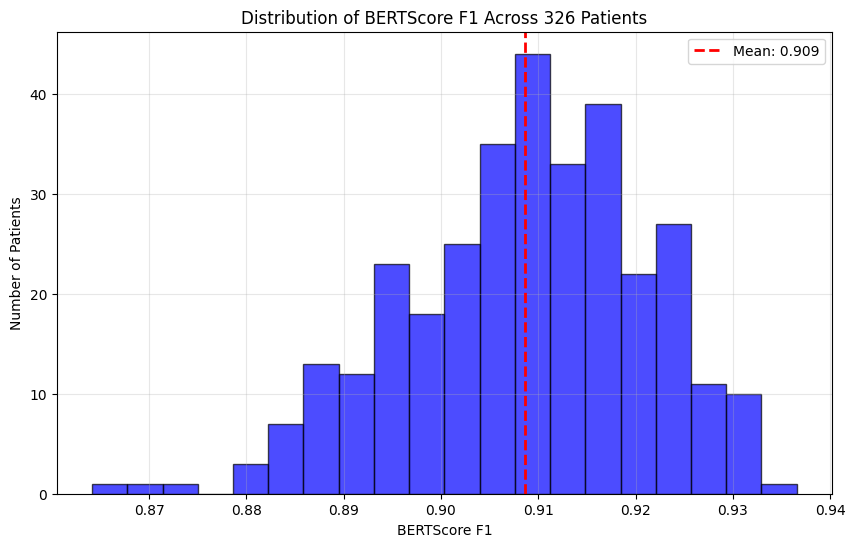


=== DISTRIBUTION STATISTICS ===
         rouge1_f    rougeL_f        bleu      meteor  bertscore_f1
count  326.000000  326.000000  326.000000  326.000000    326.000000
mean     0.714425    0.666815    0.471163    0.705888      0.908587
std      0.091334    0.100073    0.089894    0.070752      0.012381
min      0.403292    0.353909    0.229822    0.477908      0.864143
25%      0.658654    0.598756    0.408480    0.667025      0.901286
50%      0.720000    0.666667    0.473263    0.703865      0.908938
75%      0.773490    0.742279    0.535315    0.748079      0.917086
max      0.972477    0.960452    0.685012    0.966601      0.936557


In [ ]:
# Create histogram of BERTScore distribution
plt.figure(figsize=(10, 6))
plt.hist(metrics_df['bertscore_f1'], bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.axvline(metrics_df['bertscore_f1'].mean(), color='red', linestyle='dashed', linewidth=2, label=f'Mean: {metrics_df["bertscore_f1"].mean():.3f}')
plt.xlabel('BERTScore F1')
plt.ylabel('Number of Patients')
plt.title('Distribution of BERTScore F1 Across 326 Patients')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Show summary statistics
print("\n=== DISTRIBUTION STATISTICS ===")
print(metrics_df[['rouge1_f', 'rougeL_f', 'bleu', 'meteor', 'bertscore_f1']].describe())

/tmp/ipython-input-3249801561.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


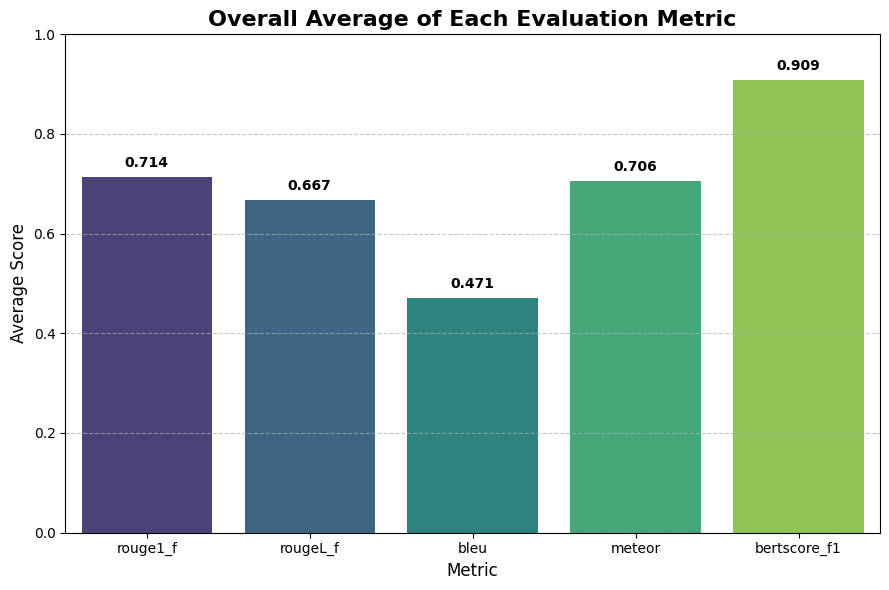

In [ ]:
# Calculate overall averages for each metric
overall_averages = metrics_df[['rouge1_f', 'rougeL_f', 'bleu', 'meteor', 'bertscore_f1']].mean()

# Plot
plt.figure(figsize=(9, 6))
barplot = sns.barplot(
    x=overall_averages.index,
    y=overall_averages.values,
    palette='viridis'
)
plt.title('Overall Average of Each Evaluation Metric', fontsize=16, weight='bold')
plt.ylabel('Average Score', fontsize=12)
plt.xlabel('Metric', fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Optional: Add value labels on top of bars
for i, v in enumerate(overall_averages.values):
    barplot.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

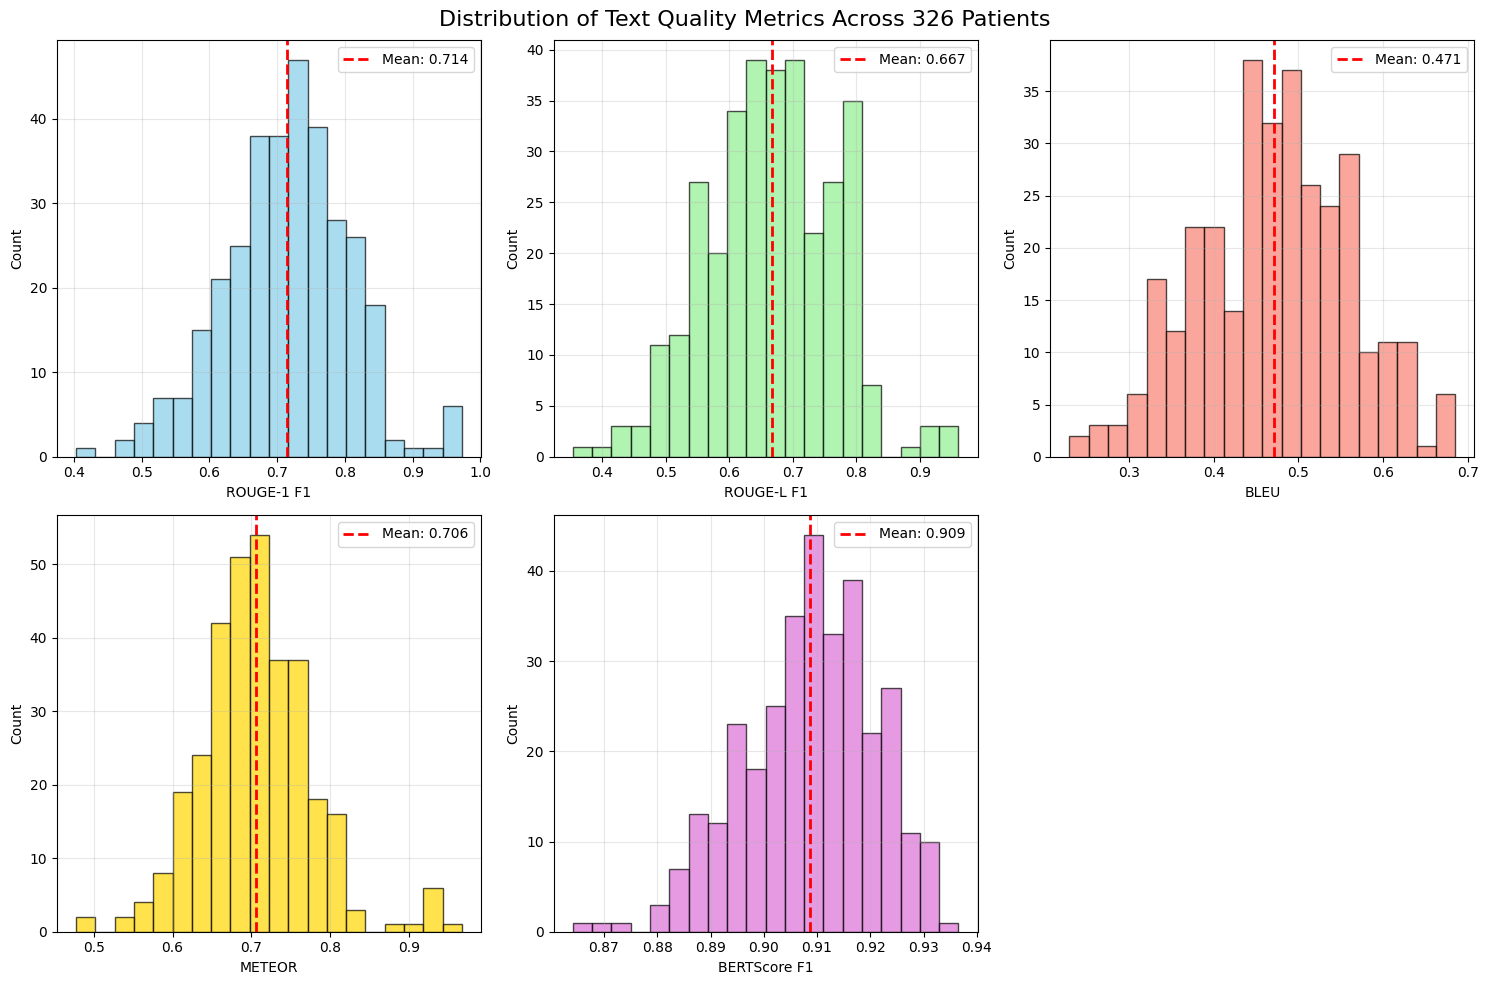

In [ ]:
import os # Ensure os module is imported for directory operations

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution of Text Quality Metrics Across 326 Patients', fontsize=16)

metrics = ['rouge1_f', 'rougeL_f', 'bleu', 'meteor', 'bertscore_f1']
titles = ['ROUGE-1 F1', 'ROUGE-L F1', 'BLEU', 'METEOR', 'BERTScore F1']
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid']

for idx, (metric, title, color) in enumerate(zip(metrics, titles, colors)):
    ax = axes[idx//3, idx%3]
    ax.hist(metrics_df[metric], bins=20, alpha=0.7, color=color, edgecolor='black')
    ax.axvline(metrics_df[metric].mean(), color='red', linestyle='dashed',
               linewidth=2, label=f'Mean: {metrics_df[metric].mean():.3f}')
    ax.set_xlabel(title)
    ax.set_ylabel('Count')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Remove empty subplot if needed
if len(metrics) < 6:
    axes[1, 2].set_visible(False)

plt.tight_layout()

# Create the directory if it does not exist
output_figure_dir = '/content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures/'
os.makedirs(output_figure_dir, exist_ok=True)

plt.savefig(os.path.join(output_figure_dir, 'metrics_distributions.png'),
            dpi=300, bbox_inches='tight')
plt.show()

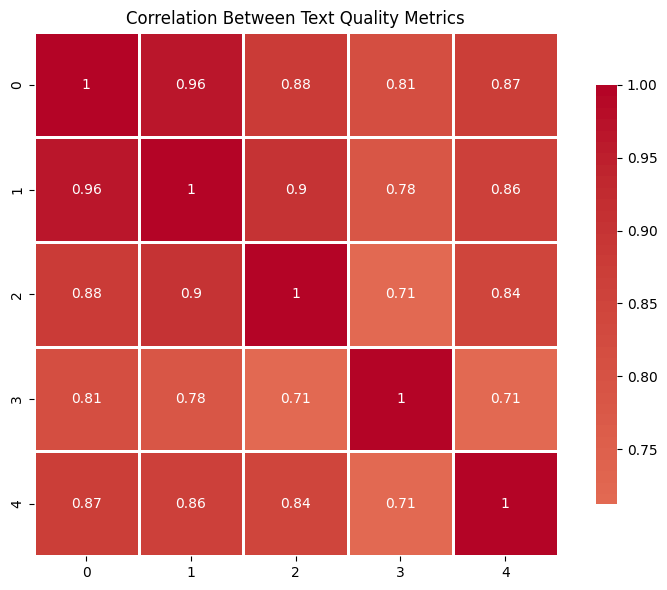

In [ ]:
# Calculate correlation matrix
corr_matrix = metrics_df[['rouge1_f', 'rougeL_f', 'bleu', 'meteor', 'bertscore_f1']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Between Text Quality Metrics')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures/metrics_correlation.png',
            dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipython-input-647339138.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot(box_data, labels=labels, patch_artist=True)


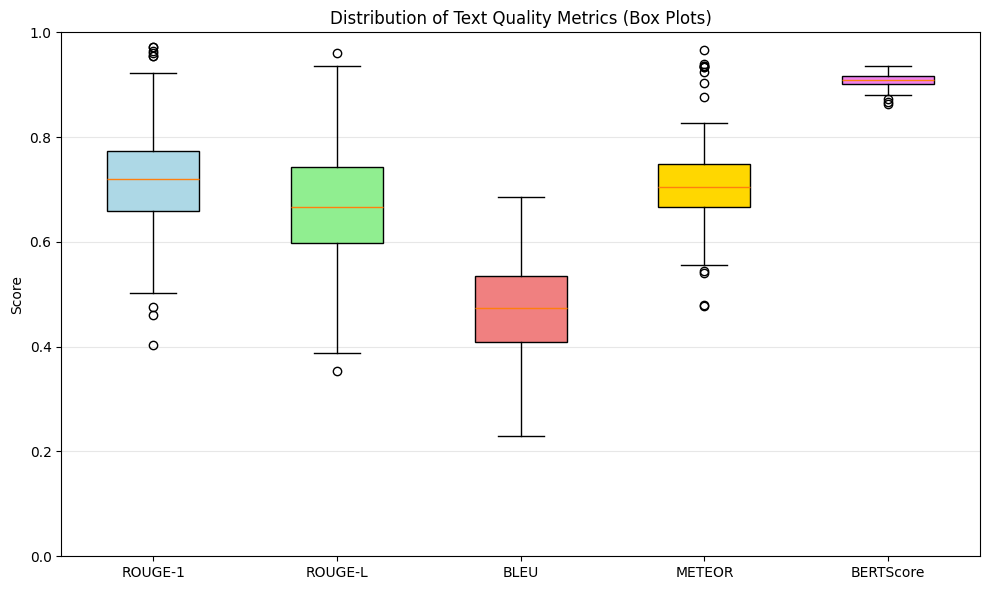

In [ ]:
plt.figure(figsize=(10, 6))
box_data = [metrics_df['rouge1_f'], metrics_df['rougeL_f'],
            metrics_df['bleu'], metrics_df['meteor'], metrics_df['bertscore_f1']]
labels = ['ROUGE-1', 'ROUGE-L', 'BLEU', 'METEOR', 'BERTScore']

box = plt.boxplot(box_data, labels=labels, patch_artist=True)
colors = ['lightblue', 'lightgreen', 'lightcoral', 'gold', 'violet']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Score')
plt.title('Distribution of Text Quality Metrics (Box Plots)')
plt.grid(True, alpha=0.3, axis='y')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures/metrics_boxplot.png',
            dpi=300, bbox_inches='tight')
plt.show()

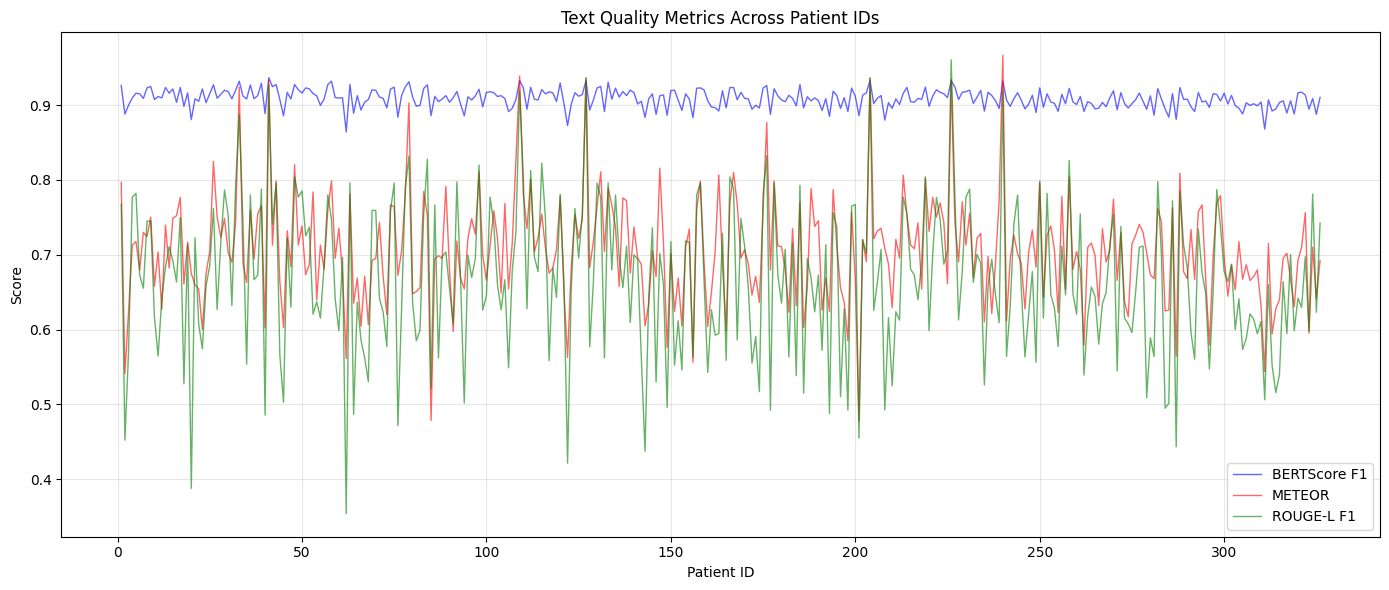

In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(metrics_df['patient_id'], metrics_df['bertscore_f1'],
         'b-', alpha=0.6, linewidth=1, label='BERTScore F1')
plt.plot(metrics_df['patient_id'], metrics_df['meteor'],
         'r-', alpha=0.6, linewidth=1, label='METEOR')
plt.plot(metrics_df['patient_id'], metrics_df['rougeL_f'],
         'g-', alpha=0.6, linewidth=1, label='ROUGE-L F1')

plt.xlabel('Patient ID')
plt.ylabel('Score')
plt.title('Text Quality Metrics Across Patient IDs')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures/metrics_by_patient.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def apply_synonyms(text: str) -> str:
    """Replace known misspellings/variants in a findings string using SYNONYMS."""
    if not isinstance(text, str) or not text.strip():
        return text

    out = text
    for wrong, right in SYNONYMS.items():
        pattern = r"\b" + re.escape(wrong) + r"\b"
        out = re.sub(pattern, right, out, flags=re.IGNORECASE)
    return out

# Synonyms from PDF
SYNONYMS = {
    "speculated": "spiculated",
    "heterogenous": "heterogeneous",
    "heterogenously": "heterogeneous",
    "homogenous": "homogeneous",
    "non enhancement": "no_enhancement",
    "imln": "lymph_nodes",
    "tortous": "tortuous",
    "leisons": "lesions",
    "malibnant": "malignant",
    "suspisious": "suspicious",
    "suspicous": "suspicious",
    "benign macrocalcifications": "macrocalcification",
    "macrocalcifications": "macrocalcification",
    "microcalcification": "microcalcifications",
    "cluster": "clustered",
    "clusters": "clustered",
    "superior": "upper",
    "inferior": "lower",
    "medial": "inner",
    "lateral": "outer"
}
# Categorize primitives from PDF
CANONICALS = {
    "version": "1.0",
    "categories": {
        "suspicion_level": ["normal", "benign", "suspicious", "malignant"],
        "lesion_type": ["mass", "non_mass", "asymmetry", "architectural_distortion", "calcifications",
                       "lymph_nodes", "postoperative_change", "edema", "dilated_duct", "cyst", "adenosis",
                       "hamartoma", "vascular_calcifications", "prominent_ducts"],
        "mass_attributes": ["circumscribed", "obscured", "indistinct", "microlobulated", "spiculated",
                           "regular_rim", "partial_rim", "rim", "dark_internal_septations", "homogeneous_mass",
                           "heterogeneous_mass", "ductal_extension", "satellites"],
        "nme_pattern": ["focal", "linear", "segmental", "regional", "diffuse", "ductal", "clumped",
                       "clustered_ring", "cobblestone", "patchy", "glandular"],
        "calc_morphology": ["macrocalcification", "microcalcifications", "pleomorphic", "punctate",
                           "vascular", "linear_branching"],
        "calc_distribution": ["clustered", "segmental", "regional", "diffuse"],
        "modifiers_signs": ["nipple_retraction", "skin_retraction", "skin_thickening", "contour_bulge",
                           "air_gas", "recurrence", "surgical_clips", "flap", "portacath"],
        "extent_location": ["multiple", "multifocal", "multicentric", "axillary", "retroareolar", "central",
                           "upper", "lower", "inner", "outer", "upper_outer", "upper_inner", "lower_outer",
                           "lower_inner"]
    }
}

# Map sheet → lesion type
LESION_TYPE_MAP = {
    "mass_description": "mass",
    "distortion": "architectural_distortion",
    "postoperative": "postoperative_change",
    "postneoajuvant chemotherapy": "treatment_change",
    "asymmetry": "asymmetry",
    "calcifications": "calcifications",
    "mass enhancement_description": "mass_enhancement",
    "nonmass enhancement_description": "nonmass_enhancement",
    # "all" sheet might be mixed/general
    "all": "mixed",
}

STANDARD_RENAMES = {
    "Breast density (ACR)": "ACR",
    "Pathology Classification/ Follow up": "Pathology",
}

IMAGE_COL_CANDIDATES = ["Image_name", "Image Name", "Image_ID", "Image ID", "image_name", "image_id"]

VIEW_POSITION = {
    "CC": "top-down view",
    "MLO": "upper outer quadrant and chest muscle view"
}

DENSITY_DESCRIPTION = {
    "A": "Almost entirely fatty breast tissue.",
    "B": "Scattered fibroglandular tissue.",
    "C": "Heterogeneously dense breast tissue.",
    "D": "Extremely dense breast tissue."
}

In [ ]:
import json
from collections import defaultdict

def acr_to_density_letter(acr_value):
    """Convert raw ACR (A/B/C/D or numeric 1-4) into standardized A–D letter."""
    if pd.isna(acr_value):
        return None
    s = str(acr_value).strip().upper()
    # already a letter?
    if s in {"A", "B", "C", "D"}:
        return s
    # numeric 1–4 → A–D
    if s in {"1", "2", "3", "4"}:
        return chr(ord("A") + int(s) - 1)
    return None

def infer_location_from_text(text: str):
    """
    Infer location keywords like upper/lower/inner/outer from the findings sentence.
    Returns one of: upper, lower, inner, outer, upper_outer, upper_inner,
    lower_outer, lower_inner, or None.
    """
    if not isinstance(text, str):
        return None

    # Apply synonyms first to standardize terms
    standardized_text = apply_synonyms(text.lower())

    t = standardized_text

    # Check for combined locations first (most specific)
    if "upper outer" in t or "outer upper" in t:
        return "upper_outer"
    if "upper inner" in t or "inner upper" in t:
        return "upper_inner"
    if "lower outer" in t or "outer lower" in t:
        return "lower_outer"
    if "lower inner" in t or "inner lower" in t:
        return "lower_inner"

    # Check for single locations
    if "upper" in t:
        return "upper"
    if "lower" in t:
        return "lower"
    if "inner" in t:
        return "inner"
    if "outer" in t:
        return "outer"

    return None

def parse_birads_list(value):
    """
    Return ALL BIRADS digits in a cell as a list.
    Examples:
      '3$2'        -> [3, 2]
      'BIRADS 4'   -> [4]
      None / ''    -> []
    """
    if pd.isna(value):
        return []
    s = str(value)
    # simplest & robust for patterns like '3$2', '3 2', 'BIRADS 3'
    return [int(ch) for ch in s if ch.isdigit()]

def build_mass_description_from_row(r: pd.Series) -> str | None:
    """
    For rows in mass_description / mass enhancement_description sheets,
    build a sentence using Mass density/enhancement pattern, Mass shape,
    and Mass margin. If nothing useful is present, return None.
    """
    # column names from your screenshots – adjust if slightly different
    density_col_candidates = [
        "Mass density/enhancement pattern",
        "mass density/enhancement pattern",
    ]
    shape_col_candidates = ["Mass shape", "mass shape"]
    margin_col_candidates = ["Mass margin", "mass margin"]

    def get_first(colnames):
        for c in colnames:
            if c in r.index and pd.notna(r[c]) and str(r[c]).strip():
                return str(r[c]).strip()
        return None

    dens  = get_first(density_col_candidates)   # e.g. "High"
    shape = get_first(shape_col_candidates)     # e.g. "Oval"
    margin = get_first(margin_col_candidates)   # e.g. "Circumscribed"

    if not dens and not shape and not margin:
        return None

    parts = []

    # density / enhancement
    if dens:
        parts.append(dens.lower())   # "high" / "equal" / "heterogeneous"

    # shape + the word "mass"
    if shape:
        parts.append(shape.lower())  # "oval"
        parts.append("mass")
    else:
        parts.append("mass")

    # margin
    if margin:
        parts.append("with")
        parts.append(margin.lower() + " margin")

    sentence = " ".join(parts)
    sentence = sentence[0].upper() + sentence[1:] + "."

    return sentence


def normalize_breast_portion(loc):
    """
    Keep only valid labels; if something weird appears, drop it.
    (We keep the detailed combos because your prompt can say
    'upper outer quadrant of the breast' etc.)
    """
    if not isinstance(loc, str):
        return None
    loc = loc.lower().strip()
    valid = {
        "upper",
        "lower",
        "inner",
        "outer",
        "upper_outer",
        "upper_inner",
        "lower_outer",
        "lower_inner",
    }
    return loc if loc in valid else None

def row_to_lesion_segments(raw_findings, mass_desc, birads_list):
    """
    Given:
      - raw_findings: original Excel string (may contain '$')
      - mass_desc   : optional mass sentence from shape/margin/pattern
      - birads_list : list of ints extracted from the BIRADS cell
    Return a list of (finding_text, birads_val, location_source).
    """
    # MULTI-LESION CASE: '$' separates different findings
    if isinstance(raw_findings, str) and "$" in raw_findings:
        # split & clean
        base_segs = [seg.strip() for seg in raw_findings.split("$") if seg.strip()]
        base_segs = [apply_synonyms(seg) for seg in base_segs]

        if not base_segs:
            return []

        # decide BIRADS per segment
        if len(birads_list) == len(base_segs):
            b_list = birads_list
        elif birads_list:  # e.g. ['3'] for many segments
            b_list = [birads_list[0]] * len(base_segs)
        else:
            b_list = [None] * len(base_segs)

        return [(text, b, text) for text, b in zip(base_segs, b_list)]

    # SINGLE-LESION CASE
    clean_findings = (
        apply_synonyms(raw_findings).replace("$", ". ").strip()
        if isinstance(raw_findings, str) and raw_findings.strip()
        else ""
    )

    if mass_desc and clean_findings:
        finding_text = f"{mass_desc} {clean_findings}"
        loc_source = raw_findings or mass_desc
    elif mass_desc:
        finding_text = mass_desc
        loc_source = mass_desc
    else:
        finding_text = clean_findings
        loc_source = raw_findings

    if not finding_text:
        return []

    birads_val = birads_list[0] if birads_list else None
    return [(finding_text, birads_val, loc_source)]

In [ ]:
def excel_group_to_patient_json(g: pd.DataFrame) -> dict:
    """
    Build a patient-level JSON summary for one patient using Excel data.
    - Keeps all lesion-level BIRADS (incl. multi like '3$2').
    - Breast-level BIRADS is max of that breast's lesions.
    - ACR may be missing; then density_* stays None.
    - ✅ NOW uses ONLY TEXT-BASED LOCATION (no shapepoint quadrants in the report).
    """
    g = g.copy()  # safe editing

    # ---- basic patient info ----
    pid = int(g["Patient_ID"].iloc[0])

    # age -- not needed, maybe later on?
    age = g["Age"].dropna().iloc[0] if "Age" in g.columns and g["Age"].notna().any() else None

    # --- PER-BREAST ACR LETTERS ---
    if "Side" in g.columns and "ACR" in g.columns:
        side_series = g["Side"].astype(str).str.strip().str.upper()

        # left
        left_acr_vals = g.loc[side_series == "L", "ACR"]
        if left_acr_vals.notna().any():
            left_acr_letter = acr_to_density_letter(left_acr_vals.dropna().iloc[0])
        else:
            left_acr_letter = None

        # right
        right_acr_vals = g.loc[side_series == "R", "ACR"]
        if right_acr_vals.notna().any():
            right_acr_letter = acr_to_density_letter(right_acr_vals.dropna().iloc[0])
        else:
            right_acr_letter = None
    else:
        left_acr_letter = None
        right_acr_letter = None

    # --- EXAM-LEVEL ACR (ONLY IF BOTH SIDES MATCH) ---
    density_overall = None
    if left_acr_letter and right_acr_letter and left_acr_letter == right_acr_letter:
        density_overall = left_acr_letter

    patient = {
        "patient_id": pid,
        "age": int(age) if age is not None else None,

        # exam-level ACR (may be None)
        "density_overall": density_overall,
        "density_text": DENSITY_DESCRIPTION.get(density_overall) if density_overall else None,

        # per-breast ACR + description
        "left": {
            "acr": left_acr_letter,
            "acr_text": DENSITY_DESCRIPTION.get(left_acr_letter) if left_acr_letter else None,
            "findings": [],
            "birads_value": None,
            "opinion_text": None,
        },
        "right": {
            "acr": right_acr_letter,
            "acr_text": DENSITY_DESCRIPTION.get(right_acr_letter) if right_acr_letter else None,
            "findings": [],
            "birads_value": None,
            "opinion_text": None,
        },
    }

    birads_left, birads_right = [], []

    # we will aggregate findings by (modality, description) per breast
    agg = {"left": {}, "right": {}}

    # Helper add one lesion record
    def add_record(
        breast_key,
        typ,
        view,
        sheet,
        finding_text,
        birads_val,
        loc_source,
        lesion_type,
        pathology,
    ):
        if not finding_text:
            return

        # ---------- LOCATION LOGIC (TEXT-ONLY) ----------
        raw_loc = None

        # If loc_source is a string, try to treat it as either a canonical label
        # (upper_outer, etc.) or infer from its words.
        if loc_source is not None and isinstance(loc_source, str):
            if loc_source in {
                "upper", "lower", "inner", "outer",
                "upper_outer", "upper_inner", "lower_outer", "lower_inner"
            }:
                raw_loc = loc_source
            else:
                raw_loc = infer_location_from_text(loc_source)
        else:
            # No explicit loc_source → infer from the finding text itself.
            raw_loc = infer_location_from_text(finding_text)

        # Coarsen into something safe to say (upper/lower/inner/outer or combined)
        location = normalize_breast_portion(raw_loc)

        # key to identify "same lesion" across different sheets
        key = (typ, finding_text)

        record = {
            "lesion_type": lesion_type,
            "description": finding_text,
            "modality": typ or None,
            "view": None,  # we won't use it in the text
            "views": [view] if view else [],
            "breast_portion": location,
            "birads": birads_val,
            "pathology": pathology,
            "_source_sheet": sheet,
        }

        existing = agg[breast_key].get(key)
        if existing is None:
            agg[breast_key][key] = record
        else:
            # merge views
            if view and view not in existing.get("views", []):
                existing["views"].append(view)
            # Choose better record using logic instead of arbitrary numbers
            better = False

            # Prefer records that have BIRADS over those that don't
            if existing["birads"] is None and birads_val is not None:
                better = True
            # Prefer more specific sheet types over "all"
            elif sheet != "all" and existing.get("_source_sheet") == "all":
                better = True
            # Prefer longer descriptions (more detailed)
            elif len(finding_text) > len(existing["description"]):
                better = True

            if better:
                agg[breast_key][key] = record

        # collect for breast-level BIRADS
        if birads_val is not None:
            if breast_key == "left":
                birads_left.append(birads_val)
            else:
                birads_right.append(birads_val)

    #--- walk rows ---
    for _, r in g.iterrows():
        side = str(r.get("Side", "")).strip().upper()
        if side not in {"L", "R"}:
            continue
        breast_key = "left" if side == "L" else "right"

        typ = str(r.get("Type", "")).strip()  # DM / CM in the sheet
        # ✅ Normalize "CM" to "CESM" so it matches the system prompt
        if typ.upper() == "CM":
            typ = "CESM"

        view = str(r.get("View", "")).strip().upper()   # CC / MLO
        sheet = str(r.get("__sheet__", "")).strip()

        lesion_type = LESION_TYPE_MAP.get(sheet, None)

        # ----- build description -----
        raw_findings = str(r.get("Findings", "")).strip()

        # pathology & BIRADS
        pathology = str(r.get("Pathology", "")).strip() if pd.notna(r.get("Pathology", None)) else None
        birads_list = parse_birads_list(r.get("BIRADS", None))

        # possible mass description from shape/margin/pattern
        mass_desc = None
        if sheet in {"mass_description", "mass enhancement_description"}:
            mass_desc = build_mass_description_from_row(r)

        # one helper call instead of many if/elses
        segments = row_to_lesion_segments(raw_findings, mass_desc, birads_list)

        for finding_text, b_val, loc_source in segments:
            add_record(
                breast_key,
                typ,
                view,
                sheet,
                finding_text,
                b_val,
                loc_source,
                lesion_type,
                pathology,
            )

    # flatten agg into findings lists
    for breast_key in ("left", "right"):
        findings = list(agg[breast_key].values())
        patient[breast_key]["findings"] = findings

    # breast-level BIRADS = max lesion birads
    if birads_left:
        patient["left"]["birads_value"] = max(birads_left)
    if birads_right:
        patient["right"]["birads_value"] = max(birads_right)

    return patient

In [ ]:
def extract_breast_birads_from_text(report_text):
    lines = report_text.splitlines()
    in_opinion = False
    side = None
    result = {"left": None, "right": None}

    for line in lines:
        stripped = line.strip()
        if not stripped:
            continue

        if stripped.startswith("OPINION:"):
            in_opinion = True
            continue
        if not in_opinion:
            continue

        if stripped.startswith("Right Breast:"):
            side = "right"
        elif stripped.startswith("Left Breast:"):
            side = "left"
        elif side and "(BIRADS" in stripped:
            m = re.search(r"\(BIRADS\s+(\d)\)", stripped)
            if m:
                result[side] = int(m.group(1))
                side = None  # reset after match

    return result

In [ ]:
excel_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Radiology-manual-annotations.xlsx"
df = pd.read_excel(excel_path)

print(f"Loaded DataFrame with shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")

Loaded DataFrame with shape: (2006, 12)
Columns: ['Image_name', 'Patient_ID', 'Side', 'Type', 'Age', 'Breast density (ACR)', 'BIRADS', 'Findings', 'View', 'Tags', 'Machine', 'Pathology Classification/ Follow up']


In [ ]:
patient_jsons = {}

for pid, g in df.groupby("Patient_ID"):
    if pd.isna(pid):
        continue
    pid = int(pid)
    data = excel_group_to_patient_json(g)
    patient_jsons[pid] = data

print(f"Created patient_jsons with {len(patient_jsons)} patients")

Created patient_jsons with 326 patients


In [ ]:
# ===== CELL 18.5: SETUP FOR BIRADS EVALUATION =====

import os
import pandas as pd

# 1. Define test_ids (which patients to evaluate)
# Option A: All patients (recommended)
test_ids = list(patient_jsons.keys())
print(f"✅ Will evaluate ALL {len(test_ids)} patients")

# Option B: Specific range (e.g., last 36 for test set)
# test_ids = [pid for pid in patient_jsons.keys() if pid >= 291]  # Example
# print(f"Evaluating TEST SET: {len(test_ids)} patients")

# 2. Define GEN_DIR (if not already defined)
GEN_DIR = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2"
print(f"📁 Generated reports directory: {GEN_DIR}")

# 3. Check that generated reports exist
print("\n📊 Checking generated report availability...")
missing_reports = []
for pid in test_ids[:10]:  # Check first 10 as sample
    report_path = os.path.join(GEN_DIR, f"P{pid}_report.docx")
    if os.path.exists(report_path):
        print(f"  ✅ Patient {pid}: Report found")
    else:
        print(f"  ❌ Patient {pid}: Report missing")
        missing_reports.append(pid)

if missing_reports:
    print(f"\n⚠️ Warning: {len(missing_reports)} reports missing in first 10 patients")
else:
    print("\n✅ All sample reports found!")

# 4. Import required function (if not already imported)
try:
    extract_breast_birads_from_text
except NameError:
    print("\n❌ extract_breast_birads_from_text is not defined!")
    print("Make sure to run Cell 14/15 first.")

✅ Will evaluate ALL 326 patients
📁 Generated reports directory: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/Output-ver2

📊 Checking generated report availability...
  ✅ Patient 1: Report found
  ✅ Patient 2: Report found
  ✅ Patient 3: Report found
  ✅ Patient 4: Report found
  ✅ Patient 5: Report found
  ✅ Patient 6: Report found
  ✅ Patient 7: Report found
  ✅ Patient 8: Report found
  ✅ Patient 9: Report found
  ✅ Patient 10: Report found

✅ All sample reports found!


In [ ]:
# ===== CELL 19: BUILD GROUND TRUTH AND PREDICTION DATAFRAMES =====

print("\n" + "="*60)
print("BUILDING GROUND TRUTH AND PREDICTION DATAFRAMES")
print("="*60)

# ---- STEP 1: Ground truth from patient_jsons (Excel → JSON) ----
def build_ground_truth_df(patient_jsons, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), true_birads
    """
    rows = []
    for pid in patient_ids:
        pj = patient_jsons[pid]

        # Left breast
        true_left = pj["left"].get("birads_value")
        if true_left is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "true_birads": int(true_left),
            })

        # Right breast
        true_right = pj["right"].get("birads_value")
        if true_right is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "true_birads": int(true_right),
            })

    return pd.DataFrame(rows)


# ---- STEP 2: Predictions from generated DOCX reports ----
from docx import Document

def docx_to_text(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs)

def build_predictions_df(gen_dir, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), predicted_birads
    Uses your extract_breast_birads_from_text() helper.
    """
    rows = []
    for pid in patient_ids:
        gen_path = os.path.join(gen_dir, f"P{pid}_report.docx")
        if not os.path.exists(gen_path):
            print(f"Skipping {pid}: generated DOCX not found")
            continue

        gen_text = docx_to_text(gen_path)
        pred = extract_breast_birads_from_text(gen_text)

        # Left breast prediction
        if pred.get("left") is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "predicted_birads": int(pred["left"]),
            })

        # Right breast prediction
        if pred.get("right") is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "predicted_birads": int(pred["right"]),
            })

    return pd.DataFrame(rows)


# Build both tables for your TEST set
print("\nBuilding ground truth DataFrame...")
gt_df = build_ground_truth_df(patient_jsons, test_ids)

print("Building predictions DataFrame...")
pred_df = build_predictions_df(GEN_DIR, test_ids)

print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"Ground truth rows: {len(gt_df)}")
print(f"Prediction rows: {len(pred_df)}")

# Calculate expected vs actual
expected_rows = len(test_ids) * 2  # 2 breasts per patient
print(f"\n📈 Coverage:")
print(f"  • Expected (max): {expected_rows} rows ({len(test_ids)} patients × 2 breasts)")
print(f"  • Ground truth: {len(gt_df)} rows ({len(gt_df)/expected_rows:.1%} coverage)")
print(f"  • Predictions: {len(pred_df)} rows ({len(pred_df)/expected_rows:.1%} coverage)")

print("\n📋 Ground Truth Sample:")
display(gt_df.head())

print("\n📋 Predictions Sample:")
display(pred_df.head())


BUILDING GROUND TRUTH AND PREDICTION DATAFRAMES

Building ground truth DataFrame...
Building predictions DataFrame...

RESULTS SUMMARY
Ground truth rows: 566
Prediction rows: 566

📈 Coverage:
  • Expected (max): 652 rows (326 patients × 2 breasts)
  • Ground truth: 566 rows (86.8% coverage)
  • Predictions: 566 rows (86.8% coverage)

📋 Ground Truth Sample:


,patient_id,side,true_birads
0,1,L,4
1,2,L,2
2,2,R,3
3,3,L,5
4,3,R,2



📋 Predictions Sample:


,patient_id,side,predicted_birads
0,1,L,4
1,2,L,2
2,2,R,3
3,3,L,5
4,3,R,2


In [ ]:
# ===== CELL 20: CREATE CONFUSION MATRIX =====

print("="*60)
print("CREATING BIRADS CLASSIFICATION CONFUSION MATRIX")
print("="*60)

# Check if required DataFrames exist
if 'gt_df' not in locals() or 'pred_df' not in locals():
    print("❌ ERROR: gt_df and/or pred_df are not defined!")
    print("Please run Cell 19 first to build the DataFrames.")
else:
    # 1. Merge ground truth and predictions
    print(f"\nMerging ground truth ({len(gt_df)} rows) and predictions ({len(pred_df)} rows)...")

    # Use inner join to only keep patients with both ground truth AND predictions
    merged_df = pd.merge(gt_df, pred_df, on=['patient_id', 'side'], how='inner')

    if len(merged_df) == 0:
        print("❌ ERROR: No matching rows found between ground truth and predictions!")
        print("Check that patient IDs and sides match in both DataFrames.")
    else:
        print(f"✅ Successfully merged {len(merged_df)} breast-level predictions with ground truth")

        # ... [rest of your Cell 18 code] ...

CREATING BIRADS CLASSIFICATION CONFUSION MATRIX

Merging ground truth (566 rows) and predictions (566 rows)...
✅ Successfully merged 566 breast-level predictions with ground truth


In [ ]:
# ---- STEP 1: Ground truth from patient_jsons (Excel → JSON) ----
def build_ground_truth_df(patient_jsons, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), true_birads
    """
    rows = []
    for pid in patient_ids:
        pj = patient_jsons[pid]

        # Left breast
        true_left = pj["left"].get("birads_value")
        if true_left is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "true_birads": int(true_left),
            })

        # Right breast
        true_right = pj["right"].get("birads_value")
        if true_right is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "true_birads": int(true_right),
            })

    return pd.DataFrame(rows)


# ---- STEP 2: Predictions from generated DOCX reports ----
from docx import Document

def docx_to_text(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs)

def build_predictions_df(gen_dir, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), predicted_birads
    Uses your extract_breast_birads_from_text() helper.
    """
    rows = []
    for pid in patient_ids:
        gen_path = os.path.join(gen_dir, f"P{pid}_report.docx")
        if not os.path.exists(gen_path):
            print(f"Skipping {pid}: generated DOCX not found")
            continue

        gen_text = docx_to_text(gen_path)
        pred = extract_breast_birads_from_text(gen_text)

        # Left breast prediction
        if pred.get("left") is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "predicted_birads": int(pred["left"]),
            })

        # Right breast prediction
        if pred.get("right") is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "predicted_birads": int(pred["right"]),
            })

    return pd.DataFrame(rows)


# Build both tables for your TEST set
gt_df = build_ground_truth_df(patient_jsons, test_ids)
pred_df = build_predictions_df(GEN_DIR, test_ids)

print("Ground truth rows:", len(gt_df))
print("Prediction rows:", len(pred_df))
display(gt_df.head())
display(pred_df.head())

Ground truth rows: 566
Prediction rows: 566


,patient_id,side,true_birads
0,1,L,4
1,2,L,2
2,2,R,3
3,3,L,5
4,3,R,2


,patient_id,side,predicted_birads
0,1,L,4
1,2,L,2
2,2,R,3
3,3,L,5
4,3,R,2


CREATING BIRADS CLASSIFICATION CONFUSION MATRIX

Merging ground truth (566 rows) and predictions (566 rows)...
✅ Successfully merged 566 breast-level predictions with ground truth

🔍 DEBUGGING: Checking BIRADS values in data...
Unique BIRADS in ground truth: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
Unique BIRADS in predictions: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)]
⚠️ WARNING: Unexpected BIRADS in ground truth: [np.int64(6)]
⚠️ WARNING: Unexpected BIRADS in predictions: [np.int64(6)]

📊 Filtered out 3 rows with BIRADS outside 1-5 range
  • Remaining valid rows: 563

Creating confusion matrix...
✅ Confusion matrix saved to: /content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures/birads_confusion_matrix.png


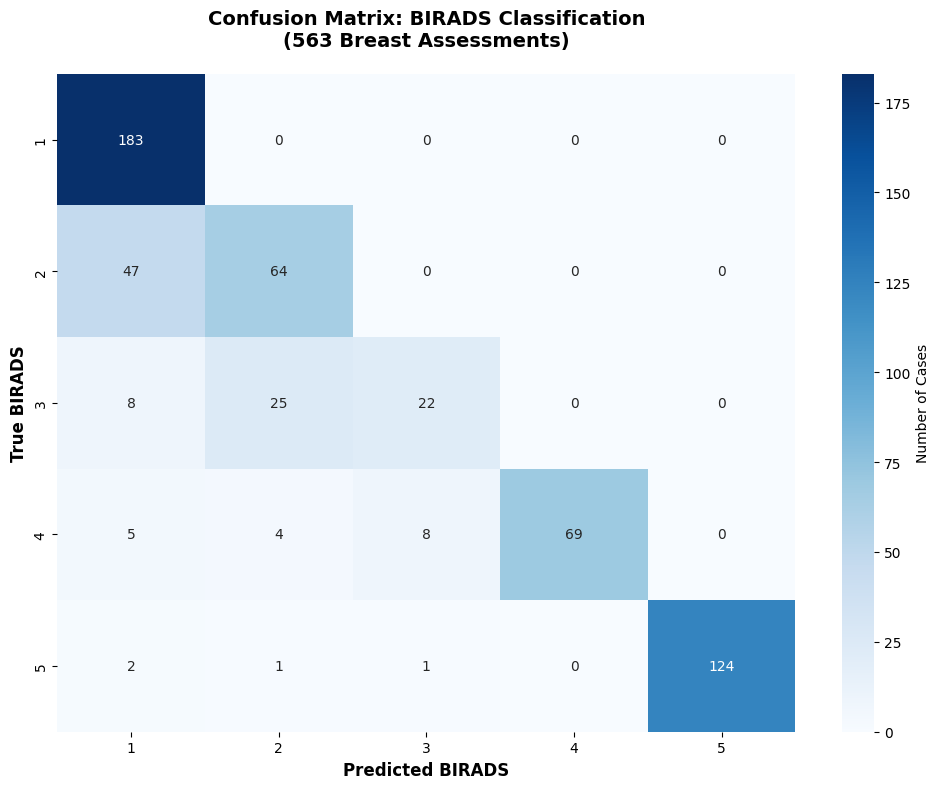


CLASSIFICATION REPORT (BIRADS 1-5 only)
              precision    recall  f1-score   support

    BIRADS 1       0.75      1.00      0.86       183
    BIRADS 2       0.68      0.58      0.62       111
    BIRADS 3       0.71      0.40      0.51        55
    BIRADS 4       1.00      0.80      0.89        86
    BIRADS 5       1.00      0.97      0.98       128

    accuracy                           0.82       563
   macro avg       0.83      0.75      0.77       563
weighted avg       0.83      0.82      0.81       563


📊 Overall Accuracy: 82.06%

ANALYSIS OF UNEXPECTED BIRADS VALUES

Filtered 3 rows with BIRADS outside 1-5:

Sample of filtered rows:
     patient_id side  true_birads  predicted_birads
136          85    R            6                 6
261         156    L            6                 6
335         201    R            6                 6

Unexpected BIRADS values found:
  BIRADS 6: 3 in ground truth, 3 in predictions

SAVING RESULTS
✅ Filtered results saved to: /c

In [ ]:
# ===== CELL 20: CREATE CONFUSION MATRIX =====

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

print("="*60)
print("CREATING BIRADS CLASSIFICATION CONFUSION MATRIX")
print("="*60)

# Check if required DataFrames exist
if 'gt_df' not in locals() or 'pred_df' not in locals():
    print("❌ ERROR: gt_df and/or pred_df are not defined!")
    print("Please run Cell 19 first to build the DataFrames.")
else:
    # 1. Merge ground truth and predictions
    print(f"\nMerging ground truth ({len(gt_df)} rows) and predictions ({len(pred_df)} rows)...")

    # Use inner join to only keep patients with both ground truth AND predictions
    merged_df = pd.merge(gt_df, pred_df, on=['patient_id', 'side'], how='inner')

    if len(merged_df) == 0:
        print("❌ ERROR: No matching rows found between ground truth and predictions!")
        print("Check that patient IDs and sides match in both DataFrames.")
    else:
        print(f"✅ Successfully merged {len(merged_df)} breast-level predictions with ground truth")

        # 2. Prepare arrays for confusion matrix
        true_labels = merged_df['true_birads'].values
        pred_labels = merged_df['predicted_birads'].values

        # 3. DEBUG: Check what values we actually have
        print("\n🔍 DEBUGGING: Checking BIRADS values in data...")
        unique_true = np.unique(true_labels)
        unique_pred = np.unique(pred_labels)

        print(f"Unique BIRADS in ground truth: {sorted(unique_true)}")
        print(f"Unique BIRADS in predictions: {sorted(unique_pred)}")

        # Check for unexpected values
        expected_range = set([1, 2, 3, 4, 5])
        unexpected_true = set(unique_true) - expected_range
        unexpected_pred = set(unique_pred) - expected_range

        if unexpected_true:
            print(f"⚠️ WARNING: Unexpected BIRADS in ground truth: {sorted(unexpected_true)}")
        if unexpected_pred:
            print(f"⚠️ WARNING: Unexpected BIRADS in predictions: {sorted(unexpected_pred)}")

        # 4. Filter to only valid BIRADS 1-5
        valid_mask = (true_labels >= 1) & (true_labels <= 5) & (pred_labels >= 1) & (pred_labels <= 5)
        true_labels_filtered = true_labels[valid_mask]
        pred_labels_filtered = pred_labels[valid_mask]

        if len(unexpected_true) > 0 or len(unexpected_pred) > 0:
            print(f"\n📊 Filtered out {np.sum(~valid_mask)} rows with BIRADS outside 1-5 range")
            print(f"  • Remaining valid rows: {len(true_labels_filtered)}")

        if len(true_labels_filtered) == 0:
            print("❌ ERROR: No valid BIRADS 1-5 data after filtering!")
            print("Check your data for BIRADS values outside the 1-5 range.")
        else:
            # 5. Create confusion matrix
            print("\nCreating confusion matrix...")
            cm = confusion_matrix(true_labels_filtered, pred_labels_filtered, labels=[1, 2, 3, 4, 5])

            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                        xticklabels=['1', '2', '3', '4', '5'],
                        yticklabels=['1', '2', '3', '4', '5'],
                        cbar_kws={'label': 'Number of Cases'})
            plt.xlabel('Predicted BIRADS', fontsize=12, fontweight='bold')
            plt.ylabel('True BIRADS', fontsize=12, fontweight='bold')
            plt.title(f'Confusion Matrix: BIRADS Classification\n({len(true_labels_filtered)} Breast Assessments)',
                      fontsize=14, fontweight='bold', pad=20)
            plt.tight_layout()

            # Save the figure
            figures_dir = '/content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures'
            os.makedirs(figures_dir, exist_ok=True)

            save_path = os.path.join(figures_dir, 'birads_confusion_matrix.png')
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"✅ Confusion matrix saved to: {save_path}")
            plt.show()

            # 6. Calculate accuracy metrics
            print("\n" + "="*50)
            print("CLASSIFICATION REPORT (BIRADS 1-5 only)")
            print("="*50)

            # Generate classification report
            print(classification_report(true_labels_filtered, pred_labels_filtered,
                                       target_names=['BIRADS 1', 'BIRADS 2', 'BIRADS 3', 'BIRADS 4', 'BIRADS 5']))

            accuracy = np.mean(true_labels_filtered == pred_labels_filtered)
            print(f"\n📊 Overall Accuracy: {accuracy:.2%}")

            # 7. Analyze the unexpected values
            if np.sum(~valid_mask) > 0:
                print("\n" + "="*50)
                print("ANALYSIS OF UNEXPECTED BIRADS VALUES")
                print("="*50)

                # Get the rows that were filtered out
                filtered_df = merged_df.iloc[~valid_mask]

                print(f"\nFiltered {len(filtered_df)} rows with BIRADS outside 1-5:")
                print("\nSample of filtered rows:")
                print(filtered_df.head())

                # Count of each unexpected value
                print("\nUnexpected BIRADS values found:")
                for value in sorted(set(filtered_df['true_birads'].unique()) | set(filtered_df['predicted_birads'].unique())):
                    if value < 1 or value > 5:
                        true_count = np.sum(filtered_df['true_birads'] == value)
                        pred_count = np.sum(filtered_df['predicted_birads'] == value)
                        print(f"  BIRADS {value}: {true_count} in ground truth, {pred_count} in predictions")

            # 8. Save the filtered results
            print("\n" + "="*50)
            print("SAVING RESULTS")
            print("="*50)

            # Create filtered merged DataFrame
            filtered_merged_df = merged_df.iloc[valid_mask]

            # Save filtered results
            merged_save_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/birads_evaluation_results.csv"
            filtered_merged_df.to_csv(merged_save_path, index=False)
            print(f"✅ Filtered results saved to: {merged_save_path}")

            # Also save all data (including unexpected values)
            all_save_path = "/content/drive/MyDrive/UR2PhDHuangREU/Dataset/birads_all_data.csv"
            merged_df.to_csv(all_save_path, index=False)
            print(f"✅ All data (including unexpected values) saved to: {all_save_path}")

            print("\n🎉 BIRADS evaluation complete!")

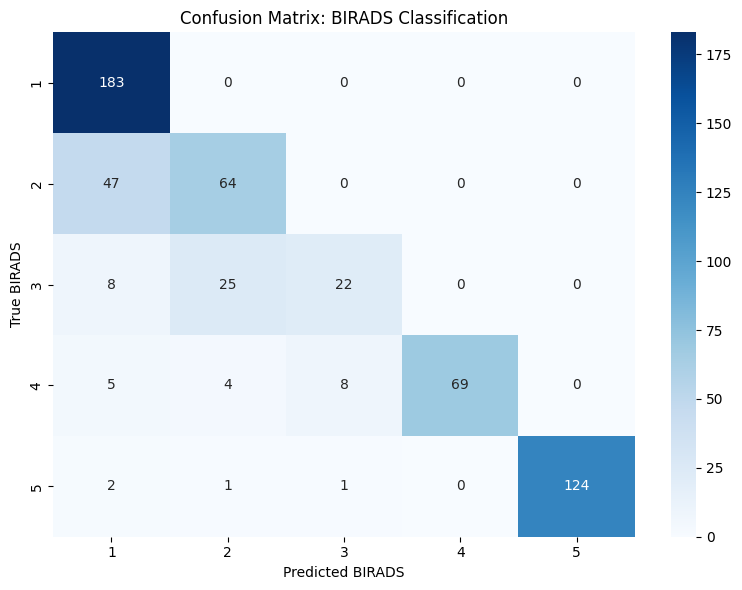

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming you have true_labels and pred_labels from your BIRADS evaluation
# If not, you'll need to run that evaluation first
cm = confusion_matrix(true_labels, pred_labels, labels=[1, 2, 3, 4, 5])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['1', '2', '3', '4', '5'],
            yticklabels=['1', '2', '3', '4', '5'])
plt.xlabel('Predicted BIRADS')
plt.ylabel('True BIRADS')
plt.title('Confusion Matrix: BIRADS Classification')
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/UR2PhDHuangREU/Dataset/figures/birads_confusion_matrix.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# ---- STEP 1: Ground truth from patient_jsons (Excel → JSON) ----
def build_ground_truth_df(patient_jsons, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), true_birads
    """
    rows = []
    for pid in patient_ids:
        pj = patient_jsons[pid]

        # Left breast
        true_left = pj["left"].get("birads_value")
        if true_left is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "true_birads": int(true_left),
            })

        # Right breast
        true_right = pj["right"].get("birads_value")
        if true_right is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "true_birads": int(true_right),
            })

    return pd.DataFrame(rows)


# ---- STEP 2: Predictions from generated DOCX reports ----
from docx import Document

def docx_to_text(path):
    doc = Document(path)
    return "\n".join(p.text for p in doc.paragraphs)

def build_predictions_df(gen_dir, patient_ids):
    """
    Build a DataFrame with one row per (patient, breast).
    Columns: patient_id, side ('L' or 'R'), predicted_birads
    Uses your extract_breast_birads_from_text() helper.
    """
    rows = []
    for pid in patient_ids:
        gen_path = os.path.join(gen_dir, f"P{pid}_report.docx")
        if not os.path.exists(gen_path):
            print(f"Skipping {pid}: generated DOCX not found")
            continue

        gen_text = docx_to_text(gen_path)
        pred = extract_breast_birads_from_text(gen_text)

        # Left breast prediction
        if pred.get("left") is not None:
            rows.append({
                "patient_id": pid,
                "side": "L",
                "predicted_birads": int(pred["left"]),
            })

        # Right breast prediction
        if pred.get("right") is not None:
            rows.append({
                "patient_id": pid,
                "side": "R",
                "predicted_birads": int(pred["right"]),
            })

    return pd.DataFrame(rows)


# Build both tables for your TEST set
gt_df = build_ground_truth_df(patient_jsons, test_ids)
pred_df = build_predictions_df(GEN_DIR, test_ids)

print("Ground truth rows:", len(gt_df))
print("Prediction rows:", len(pred_df))
display(gt_df.head())
display(pred_df.head())

Ground truth rows: 88
Prediction rows: 88


,patient_id,side,true_birads
0,4,L,1
1,4,R,1
2,13,R,3
3,14,L,1
4,14,R,4


,patient_id,side,predicted_birads
0,4,L,1
1,4,R,1
2,13,R,2
3,14,L,1
4,14,R,4


In [ ]:
# ---- STEP 3: Align and evaluate (per breast instance) ----
def align_and_evaluate(gt_df, pred_df):
    # Merge on patient_id AND side so L/R are separate instances
    merged = pd.merge(
        gt_df, pred_df,
        on=["patient_id", "side"],
        how="inner"
    )

    print("Total breast-level instances in merged data:", len(merged))

    y_true = merged["true_birads"].tolist()
    y_pred = merged["predicted_birads"].tolist()

    # Optional sanity check: how many unique patients / sides
    print("Unique patients:", merged["patient_id"].nunique())
    print("Sides count:", merged["side"].value_counts().to_dict())

    return y_true, y_pred, merged

y_true, y_pred, merged_df = align_and_evaluate(gt_df, pred_df)


Total breast-level instances in merged data: 88
Unique patients: 50
Sides count: {'L': 45, 'R': 43}


In [ ]:
# Diagnostic: Check coverage of (patient, side) pairs
expected_pairs = {(pid, side) for pid in test_ids for side in ["L", "R"]}
gt_pairs       = set(zip(gt_df["patient_id"], gt_df["side"]))
pred_pairs     = set(zip(pred_df["patient_id"], pred_df["side"]))
merged_pairs   = set(zip(merged_df["patient_id"], merged_df["side"]))

missing_in_gt   = expected_pairs - gt_pairs
missing_in_pred = expected_pairs - pred_pairs
missing_in_merged = expected_pairs - merged_pairs

print(f"Total expected breast instances: {len(expected_pairs)}")
print(f"Ground truth available:          {len(gt_pairs)}")
print(f"Predictions extracted:           {len(pred_pairs)}")
print(f"Successfully aligned (merged):   {len(merged_pairs)}\n")

if missing_in_gt:
    print("Missing in ground truth (no 'birads_value' in JSON):")
    print("   ", sorted(missing_in_gt))
if missing_in_pred:
    print("Missing in predictions (BIRADS not found in DOCX report):")
    print("   ", sorted(missing_in_pred))
if missing_in_merged:
    print("Missing in final evaluation (either GT or pred missing):")
    print("   ", sorted(missing_in_merged))

Total expected breast instances: 100
Ground truth available:          88
Predictions extracted:           88
Successfully aligned (merged):   88

Missing in ground truth (no 'birads_value' in JSON):
    [(13, 'L'), (17, 'L'), (23, 'L'), (41, 'R'), (48, 'R'), (53, 'L'), (58, 'R'), (112, 'R'), (120, 'R'), (151, 'R'), (175, 'L'), (217, 'R')]
Missing in predictions (BIRADS not found in DOCX report):
    [(13, 'L'), (17, 'L'), (23, 'L'), (41, 'R'), (48, 'R'), (53, 'L'), (58, 'R'), (112, 'R'), (120, 'R'), (151, 'R'), (175, 'L'), (217, 'R')]
Missing in final evaluation (either GT or pred missing):
    [(13, 'L'), (17, 'L'), (23, 'L'), (41, 'R'), (48, 'R'), (53, 'L'), (58, 'R'), (112, 'R'), (120, 'R'), (151, 'R'), (175, 'L'), (217, 'R')]


# Note: 12 breasts excluded due to missing BIRADS in source data (likely non-assessable)

OR they have it only on one side of the breast

Confusion Matrix (rows = true, cols = predicted):
 [[31  0  0  0  0]
 [ 5 12  0  0  0]
 [ 2  3  2  0  0]
 [ 2  0  2  9  0]
 [ 0  1  0  0 19]]


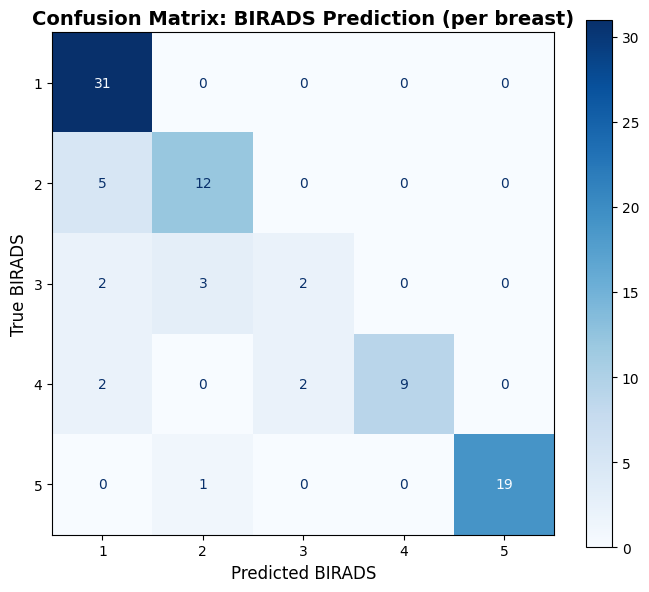


 Classification Report:
              precision    recall  f1-score   support

    BIRADS 1       0.78      1.00      0.87        31
    BIRADS 2       0.75      0.71      0.73        17
    BIRADS 3       0.50      0.29      0.36         7
    BIRADS 4       1.00      0.69      0.82        13
    BIRADS 5       1.00      0.95      0.97        20

    accuracy                           0.83        88
   macro avg       0.81      0.73      0.75        88
weighted avg       0.83      0.83      0.82        88



In [ ]:


# ---- STEP 4: Confusion matrix + metrics ----
def generate_confusion_matrix_and_report(y_true, y_pred):
    # Force labels to be [1, 2, 3, 4, 5] — standard BI-RADS categories
    LABELS = [1, 2, 3, 4, 5]

    cm = confusion_matrix(y_true, y_pred, labels=LABELS)
    print("Confusion Matrix (rows = true, cols = predicted):\n", cm)

    # Plot
    plt.figure(figsize=(7, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS)
    disp.plot(cmap=plt.cm.Blues, values_format="d", ax=plt.gca())
    plt.title("Confusion Matrix: BIRADS Prediction (per breast)", fontsize=14, weight='bold')
    plt.xlabel("Predicted BIRADS", fontsize=12)
    plt.ylabel("True BIRADS", fontsize=12)
    plt.grid(False)
    plt.tight_layout()
    plt.show()

    # Classification report (with zero_division=0 to avoid warnings for missing classes)
    print("\n Classification Report:")
    print(classification_report(
        y_true, y_pred,
        labels=LABELS,
        target_names=[f"BIRADS {l}" for l in LABELS],
        zero_division=0
    ))

# Call it
generate_confusion_matrix_and_report(y_true, y_pred)


In [ ]:

def build_acr_ground_truth_df(patient_jsons, patient_ids):
    """
    One row per patient: patient_id, true_acr (A/B/C/D).
    Uses the 'density_overall' field from your JSON.
    """
    rows = []
    for pid in patient_ids:
        pj = patient_jsons[pid]
        acr = pj.get("density_overall", None)

        if acr is not None and str(acr).strip() != "":
            rows.append({
                "patient_id": pid,
                "true_acr": str(acr).strip().upper()
            })
        else:
            print(f"[GT] Missing ACR for patient {pid}")

    return pd.DataFrame(rows)

acr_gt_df = build_acr_ground_truth_df(patient_jsons, test_ids)
print("ACR ground truth rows:", len(acr_gt_df))
display(acr_gt_df.head())


[GT] Missing ACR for patient 13
[GT] Missing ACR for patient 14
[GT] Missing ACR for patient 17
[GT] Missing ACR for patient 23
[GT] Missing ACR for patient 41
[GT] Missing ACR for patient 48
[GT] Missing ACR for patient 53
[GT] Missing ACR for patient 58
[GT] Missing ACR for patient 80
[GT] Missing ACR for patient 112
[GT] Missing ACR for patient 120
[GT] Missing ACR for patient 136
[GT] Missing ACR for patient 143
[GT] Missing ACR for patient 151
[GT] Missing ACR for patient 173
[GT] Missing ACR for patient 175
[GT] Missing ACR for patient 184
[GT] Missing ACR for patient 186
[GT] Missing ACR for patient 217
[GT] Missing ACR for patient 236
[GT] Missing ACR for patient 309
[GT] Missing ACR for patient 320
ACR ground truth rows: 28


,patient_id,true_acr
0,4,C
1,16,C
2,45,B
3,50,B
4,64,C


In [ ]:
def extract_acr_from_text(text: str):
    """
    Extract overall ACR breast density category (A/B/C/D) from radiology report.

    Looks for patterns like:
      - "ACR: B"
      - "ACR B"
      - "ACR-2"
      - "breast density (ACR C)"

    Returns: str in {'A', 'B', 'C', 'D'} or None if not found.
    """
    if not text or not isinstance(text, str):
        return None

    # Case-insensitive search for ACR + letter/number
    # \b = word boundary, \s* = optional spaces, [:\-\s] = colon, dash, or space after
    match = re.search(r"\bACR\s*([A-D1-4])\b", text, re.IGNORECASE)

    if not match:
        return None

    raw_val = match.group(1).strip().upper()

    # Map numeric ACR (1-4) to letters (A-D)
    num_to_letter = {"1": "A", "2": "B", "3": "C", "4": "D"}
    return num_to_letter.get(raw_val, raw_val)  # returns raw_val if already A-D


In [ ]:
def build_acr_predictions_df(gen_dir, patient_ids):
    """
    Extract ACR predictions from generated DOCX reports.
    Returns DataFrame: patient_id, pred_acr
    """
    rows = []
    for pid in patient_ids:
        gen_path = os.path.join(gen_dir, f"P{pid}_report.docx")
        if not os.path.exists(gen_path):
            print(f"[ACR PRED] Skipping {pid}: DOCX not found")
            continue

        text = docx_to_text(gen_path)
        pred_acr = extract_acr_from_text(text)

        if pred_acr in {"A", "B", "C", "D"}:
            rows.append({"patient_id": pid, "pred_acr": pred_acr})
        else:
            print(f"[ACR PRED] No valid ACR found in report for {pid}")

    return pd.DataFrame(rows)

# Run it!
acr_pred_df = build_acr_predictions_df(GEN_DIR, test_ids)
print("ACR prediction rows:", len(acr_pred_df))
display(acr_pred_df.head())

[ACR PRED] No valid ACR found in report for 23
[ACR PRED] No valid ACR found in report for 151
[ACR PRED] No valid ACR found in report for 184
[ACR PRED] No valid ACR found in report for 186
ACR prediction rows: 46


,patient_id,pred_acr
0,4,C
1,13,C
2,14,B
3,16,C
4,17,B


In [ ]:
# Merge on patient_id
acr_merged = pd.merge(
    acr_gt_df,
    acr_pred_df,
    on="patient_id",
    how="inner"
)

print(f"ACR evaluation pairs: {len(acr_merged)} / {len(test_ids)} patients")
display(acr_merged.head())

ACR evaluation pairs: 28 / 50 patients


,patient_id,true_acr,pred_acr
0,4,C,C
1,16,C,C
2,45,B,B
3,50,B,B
4,64,C,C


ACR Prediction Accuracy: 1.0


<Figure size 600x500 with 0 Axes>

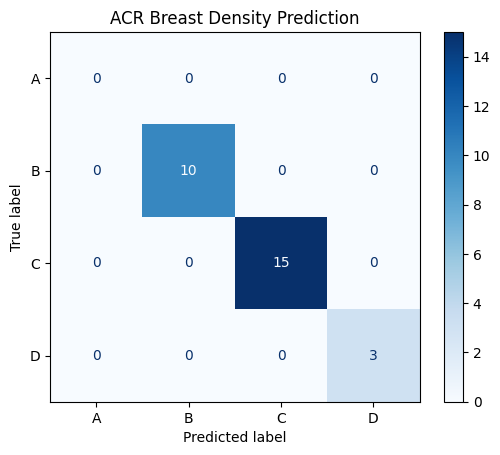

In [ ]:


if len(acr_merged) > 0:
    y_true_acr = acr_merged["true_acr"]
    y_pred_acr = acr_merged["pred_acr"]

    print("ACR Prediction Accuracy:", accuracy_score(y_true_acr, y_pred_acr))

    # Confusion matrix (A→D)
    cm_acr = confusion_matrix(y_true_acr, y_pred_acr, labels=["A", "B", "C", "D"])
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_acr, display_labels=["A", "B", "C", "D"])
    disp.plot(cmap=plt.cm.Blues, values_format="d")
    plt.title("ACR Breast Density Prediction")
    plt.grid(False)
    plt.show()
else:
    print("No ACR pairs to evaluate!")